# MCMC vs OFTI Comparison

by Sarah Blunt, 2018

Welcome to the OFTI/MCMC comparison tutorial! This tutorial is meant to help you understand the differences between OFTI and MCMC algorithms so you know which one to pick for your data. 

Before we start, I'll give you the short answer: **for orbit fractions less than 5%, OFTI is generally faster to converge than MCMC**. This is not a hard-and-fast statistical rule, but I've found it to be a useful guideline. 

This tutorial is essentially an abstract of [Blunt et al (2017)](https://ui.adsabs.harvard.edu/#abs/2017AJ....153..229B/abstract). To dig deeper, I encourage you to read the paper (Sections 2.2-2.3 in particular).

**Goals of This Tutorial**:
- Understand qualitatively why OFTI converges faster than MCMC for certain datasets.
- Learn to make educated choices of backend algorithms for your own datasets.

**Prerequisites**:
- This tutorial assumes knowledge of the `orbitize` API. Please go through at least the [OFTI](https://orbitize.readthedocs.io/en/latest/tutorials/OFTI_tutorial.html) and [MCMC](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html) introduction tutorials before this one.
- This tutorial also assumes a qualitative understanding of OFTI and MCMC algorithms. I suggest you check out at least Section 2.1 of [Blunt et al (2017)](https://ui.adsabs.harvard.edu/#abs/2017AJ....153..229B/abstract) and [this blog post](https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/) before attempting to decode this tutorial.

**Jargon**:
- I will often use **orbit fraction**, or the fraction of the orbit spanned by the astrometric observations, as a figure of merit. In general, OFTI will converge faster than MCMC for small orbit fractions. 
- **Convergence** is defined differently for OFTI and for MCMC (see the OFTI paper for details). An OFTI run needs to accept a statistically large number of orbits for convergence, since each accepted orbit is independent of all others. For MCMC, convergence is a bit more complicated. At a high level, an MCMC run has converged when all walkers have explored the entire parameter space. There are several metrics for estimating MCMC convergence (e.g. GR statistic, min Tz statistic), but we'll just estimate convergence qualitatively in this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table
import time

from orbitize.kepler import calc_orbit
from orbitize import system, sampler
from orbitize.read_input import read_file

## Generate Synthetic Data

Let's start by defining a function to generate synthetic data. This will allow us to easily test convergence speeds for different orbit fractions. I'll include the number of observations and the noise magnitude as keywords; I encourage you to test out different values throughout the tutorial!

In [2]:
mtot = 1.2 # total system mass [M_sol]
plx = 60.0 # parallax [mas]

def generate_synthetic_data(sma=30., num_obs=4, unc=10.0):
    """ Generate an orbitize-table of synethic data
    
    Args:
        sma (float): semimajor axis (au)
        num_obs (int): number of observations to generate
        unc (float): uncertainty on all simulated RA & Dec measurements (mas)
        
    Returns:
        2-tuple:
            - `astropy.table.Table`: data table of generated synthetic data
            - float: the orbit fraction of the generated data
    """

    # assumed ground truth for non-input orbital parameters
    ecc = 0.5 # eccentricity
    inc = np.pi/4 # inclination [rad]
    argp = 0.
    lan = 0. 
    tau = 0.8 

    # calculate RA/Dec at three observation epochs
    observation_epochs = np.linspace(51550., 52650., num_obs) # `num_obs` epochs between ~2000 and ~2003 [MJD]
    num_obs = len(observation_epochs)
    ra, dec, _ = calc_orbit(observation_epochs, sma, ecc, inc, argp, lan, tau, plx, mtot)

    # add Gaussian noise to simulate measurement
    ra += np.random.normal(scale=unc, size=num_obs)
    dec += np.random.normal(scale=unc, size=num_obs)
    
    # define observational uncertainties
    ra_err = dec_err = np.ones(num_obs)*unc
    
    # make a plot of the data
    plt.figure()
    plt.errorbar(ra, dec, xerr=ra_err, yerr=dec_err, linestyle='')
    plt.xlabel('$\\Delta$ RA'); plt.ylabel('$\\Delta$ Dec')
    
    # calculate the orbital fraction
    period = np.sqrt((sma**3)/mtot)
    orbit_coverage = (max(observation_epochs) - min(observation_epochs))/365.25 # [yr]
    orbit_fraction = 100*orbit_coverage/period

    data_table = astropy.table.Table(
        [observation_epochs, [1]*num_obs, ra, ra_err, dec, dec_err], 
        names=('epoch', 'object', 'raoff', 'raoff_err', 'decoff', 'decoff_err')
    )
    # read into orbitize format
    data_table = read_file(data_table)
    
    return data_table, orbit_fraction

## Short Orbit Fraction

Let's use the function above to generate some synthetic data with a short orbit fraction, and fit it with OFTI:

The orbit fraction is 2.0%


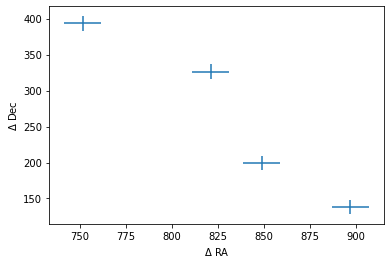

In [3]:
# generate data with default kwargs
short_data_table, short_orbit_fraction = generate_synthetic_data()
print('The orbit fraction is {}%'.format(np.round(short_orbit_fraction),1))

# initialize orbitize `System` object
short_system = system.System(1, short_data_table, mtot, plx)

num2accept = 500 # run sampler until this many orbits are accepted

In [4]:
start_time = time.time()

# set up OFTI `Sampler` object
short_OFTI_sampler = sampler.OFTI(short_system)

# perform OFTI fit
short_OFTI_orbits = short_OFTI_sampler.run_sampler(num2accept)

print("OFTI took {} seconds to accept {} orbits.".format(time.time()-start_time, num2accept))

Converting ra/dec data points in data_table to sep/pa. Original data are stored in input_table.
OFTI took 168.27709293365479 seconds to accept 500 orbits.


In [5]:
start_time = time.time()

# set up MCMC `Sampler` object
num_walkers = 20
short_MCMC_sampler = sampler.MCMC(short_system, num_temps=5, num_walkers=num_walkers)

# perform MCMC fit
num2accept_mcmc = 10*num2accept
_ = short_MCMC_sampler.run_sampler(num2accept_mcmc, burn_steps=100)
short_MCMC_orbits = short_MCMC_sampler.results.post

print("MCMC took {} steps in {} seconds.".format(num2accept_mcmc, time.time()-start_time))

Starting Burn in


/home/sblunt/Projects/orbitize/orbitize/priors.py:354: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/home/sblunt/Projects/orbitize/orbitize/priors.py:463: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


100/100 steps of burn-in complete
Burn in complete. Sampling posterior now.
250/250 steps completed
Run complete
MCMC took 5000 steps in 49.9500732421875 seconds.


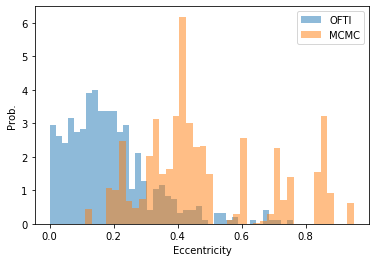

In [6]:
plt.hist(short_OFTI_orbits[:, short_system.param_idx['ecc1']], bins=40, density=True, alpha=.5, label='OFTI')
plt.hist(short_MCMC_orbits[:, short_system.param_idx['ecc1']], bins=40, density=True, alpha=.5, label='MCMC')

plt.xlabel('Eccentricity'); plt.ylabel('Prob.')
plt.legend()

These distributions are different because the MCMC chains have not converged, resulting in a "lumpy" MCMC distribution. I set up the calculation so that MCMC would return 10x as many orbits as OFTI, but even so, the OFTI distribution is a much better representation of the underlying PDF. 

If we run the MCMC algorithm for a greater number of steps (and/or increase the number of walkers and/or temperatures), the MCMC and OFTI distributions will become indistinguishable. **OFTI is NOT more correct than MCMC, but for this dataset, OFTI converges on the correct posterior faster than MCMC**. 

## Longer Orbit Fraction

Let's now repeat this exercise with a longer orbit fraction. For this dataset, OFTI will have to run for several seconds just to accept one orbit, so we won't compare the resulting posteriors.

The orbit fraction is 10.0%


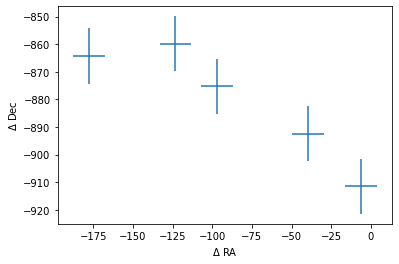

In [7]:
# generate data
long_data_table, long_orbit_fraction = generate_synthetic_data(sma=10, num_obs=5)
print('The orbit fraction is {}%'.format(np.round(long_orbit_fraction),1))

# initialize orbitize `System` object
long_system = system.System(1, long_data_table, mtot, plx)
num2accept = 500 # run sampler until this many orbits are accepted

In [8]:
start_time = time.time()

# set up OFTI `Sampler` object
long_OFTI_sampler = sampler.OFTI(long_system)

# perform OFTI fit
long_OFTI_orbits = long_OFTI_sampler.run_sampler(1)

print("OFTI took {} seconds to accept 1 orbit.".format(time.time()-start_time))

Converting ra/dec data points in data_table to sep/pa. Original data are stored in input_table.
OFTI took 9.773301124572754 seconds to accept 1 orbit.


In [9]:
start_time = time.time()

# set up MCMC `Sampler` object
num_walkers = 20
long_MCMC_sampler = sampler.MCMC(long_system, num_temps=10, num_walkers=num_walkers)

# perform MCMC fit
_ = long_MCMC_sampler.run_sampler(num2accept, burn_steps=100)
long_MCMC_orbits = long_MCMC_sampler.results.post

print("MCMC took {} steps in {} seconds.".format(num2accept, time.time()-start_time))

Starting Burn in
100/100 steps of burn-in complete
Burn in complete. Sampling posterior now.
25/25 steps completed
Run complete
MCMC took 500 steps in 50.55109786987305 seconds.


Text(0, 0.5, 'Prob.')

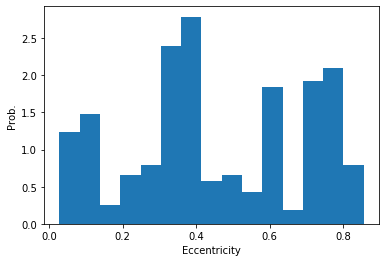

In [10]:
plt.hist(long_MCMC_orbits[:, short_system.param_idx['ecc1']], bins=15, density=True)
plt.xlabel('Eccentricity'); plt.ylabel('Prob.')

It will take more steps for this MCMC to fully converge (see the [MCMC tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html) for more detailed guidelines), but you can imagine that MCMC will converge much faster than OFTI for this dataset.

## Closing Thoughts

If you play around with the `num_obs`, `sma`, and `unc` keywords in the `generate_synthetic_data` function and repeat this exercise, you will notice that the OFTI acceptance rate and MCMC convergence rate depend on many variables, not just orbit fraction. **In truth, the Gaussianity of the posterior space determines how quickly an MCMC run will converge, and its similarity to the prior space determines how quickly an OFTI run will converge. In other words, the more constrained your posteriors are (relative to your priors), the quicker MCMC will converge, and the slower OFTI will run.**

Orbit fraction is usually a great tracer of this "amount of constraint," but it's good to understand why!

**Summary**:
- OFTI and MCMC produce the same posteriors, but often take differing amounts of time to converge on the correct solution.
- OFTI is superior when your posteriors are similar to your priors, and MCMC is superior when your posteriors are highly constrained Gaussians.